In [2]:
# Default Libraries
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az
from tqdm import tqdm

## 近似推論手法
事後分布の近似推論法
- マルコフ連鎖モンテカルロ法（MCMC）
- 変分推論法

Bayes推論が真価を発揮するような複雑な Model においては、事後分布を解析的に求めることは難しく、Parameter の事後分布の近似推論が必要になる。

### マルコフ連鎖モンテカルロ法（MCMC: Markov chain Monte Carlo methods）
Parameter の事後分布を明示的に求める代わりに、事後分布に従う乱数（Sample）を得ることで分布の性質を確認する手法。
事後分布に従う Sample を得ることで、事後分布で関心のある統計量を求めることができる。

| 用語                            | 内容                       |
|-------------------------------|--------------------------|
| マルコフ連鎖（Markov Chain）          | 確率変数の系列において、１つ前の値（状態）に基づき、次の値（状態）が決まる場合の系列のこと。 |
| 遷移確率（Transition Probability）  | １つ前の値のとき次の値になる条件確率       |
| 定常分布（Stationary Distribution） | Markov連鎖において十分な期間の経過後、変化しなくなった確率分布 |
| エルゴード性（ergodicity）            | 初期値にかかわらず、定常分布に収束する性質。   |

### モンテカルロ法（Monte Carlo Method）
乱数を用いた数値計算の総称。乱数は、確率分布に従って生成される Random な値。

In [3]:
# Example: 平均0, 標準偏差1 の Gauss分布N(0, 1)(=標準正規分布)の確率密度関数f(z) の [-2, 2]の区間での積分を計算
def montecarlo(M, trial=100, seed=1):
    """
    M個の sample による Montecarlo法を trial回繰り返し、推定値の平均と標準偏差を返す
    :param M: Sample数
    :param trial: 試行回数
    :param seed: 乱数の種
    :return: 推定値の平均と標準偏差
    """
    np.random.seed(seed)
    x = np.random.uniform(-2, 2, (M, trial))
    res = 4 * stats.norm(0, 1).pdf(x).mean(axis=0)
    return res.mean(), res.std()

ground truth: 0.9545
M= 100, estimation: 0.9574 ± 0.0426
M= 1000, estimation: 0.9520 ± 0.0144
M= 10000, estimation: 0.9548 ± 0.0048
M= 100000, estimation: 0.9543 ± 0.0015


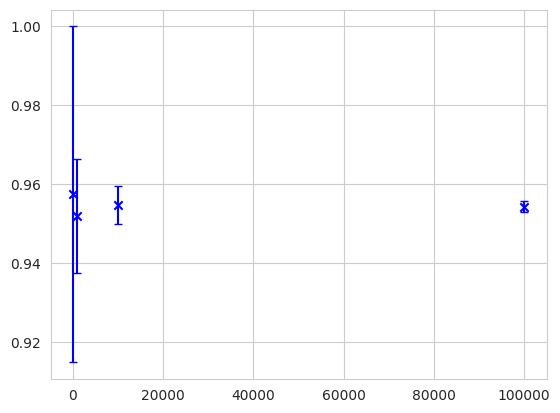

In [4]:
# 求めたい積分値の真の値
ground_truth = stats.norm(0, 1).cdf(2) - stats.norm(0, 1).cdf(-2)
print(f"ground truth: {ground_truth:.4f}")

M_list = [100, 1_000, 10_000, 100_000]
fig, ax = plt.subplots()
for M in M_list:
    m, s = montecarlo(M)
    print(f"M= {M}, estimation: {m:.4f} ± {s:.4f}")
    ax.scatter(M, m, c="b", marker="x")
    ax.errorbar(M, m, s, capsize=3, c="b")

### MCMC の Algorithm
興味のある Parameter の事後分布（目標分布）が定常分布になるように、うまく Markov連鎖の遷移確率を設計し、目標分布からの Sample を取得する。
- **詳細釣り合い条件（Detailed Balance Condition）** によって、Markov連鎖が目標分布に収束することが知られている。
- 一般的に MCMC は釣り詳細釣り合い条件を満たしている。（厳密にいうと満たさない Algorithm もある。）
- 各 MCMC-Algorithm の違いは詳細釣り合い条件を満たす遷移確率の作り方にある。

### メトロポリス・ヘイスティングス法（MH法: Metropolis-Hastings Algorithm）
- **提案分布（Proposal Distribution）** を導入し、提案分布から得られた Sample を Metropolis-Hastings基準という判定法に従い受容or棄却することによって詳細釣り合い条件を満たし目標分したがう１ Sample を得る。
- 提案分布に従う Sample（乱数）を用いた近似計算という意味で、Montecarlo法の一種と言える。
- 提案分布として Gauss分布を用いた手法は **ランダムウォークMH法** と呼ばれる。

### ハミルトニアン・モンテカルロ法（HMC法: Hamiltonian Monte Carlo method）
- 正規化されていない確率密度変数の勾配を用いるこちで、効率的に Sampling を行なう MCMC の手法。
- 解析力学的な Simulation に基づき提案する値を取得する。
- 提案された値は高次元の場合においても受容率が高くなることが期待される。
- 勾配計算が必要になるため、Sampling対象の変数が離散の場合には適用できない欠点がある。

### その他の Algorithm
#### NUTS（No U-Turn Sampler）
- HMC法を改良した Algorithm
- Stan, PyMC3 で Main の Algorithm として使用されている。
- HMC法で発生する非効率な「U-Turn」を避けるため、Sampling中に Step数: L を調整する工夫を行なう。

#### レプリカ交換モンテカルロ法（Replica Exchange Monte Carlo Method）
- 別名: **パラレル・テンパリング（Parallel Tempering）**
- 「温度」という概念を導入することで、複数の peak を持つような事後分布から効率的に Sampling する。
- 温度が高いほど、事後分布の異なる Peak の間を行き来しやすくなり、幅広い領域を探索できる。
- 温度が異なる複数の Chain（Replica）で Sampling を行ない、Chain間で Sample を時々交換することで、複数の離れた Peak を持つような目標分布からの Sampling が可能になる。

### MCMC の具体例
Gauss分布の平均Parameter に関する推論を行なう。
事後分布を MCMC により近似推論して、解析推論として、解析解と比較してみる。
Algorithm は Metropolis-Hastings法を採用

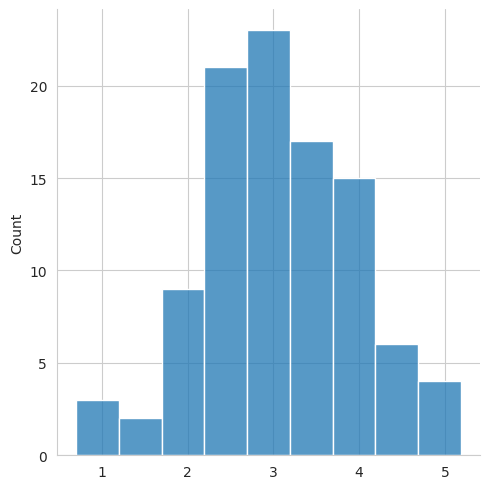

In [5]:
# 推論対象とする人工Data の作成
# Parameter の設定
n_sample = 100
true_mean = 3.0
true_sd = 1.0

np.random.seed(1)

# 人工Data の生成
data = np.random.normal(true_mean, true_sd, n_sample)

sns.displot(data, kde=False)

In [6]:
# Metropolis-Hastings法
n_iter = 6000
step_size = 0.3
z_init = 0.0

# 現在の Sample の値
z_current = z_init
# Sample を保存する List
posterior = []
# 提案分布からの Sample が受容された回数
n_accepted = 0

def unnormalized_log_posterior(z):
    """対数事後分布の計算"""
    likelihood = stats.norm(z, true_sd).logpdf(data).sum()
    prior = stats.norm(0, 10).logpdf(z)
    return prior + likelihood

In [7]:
np.random.seed(1)

for i in tqdm(range(n_iter)):
    # 攪乱項 ε は平均 0 の一様分布に従うとする
    z_proposal = z_current + step_size * np.random.uniform(-1, 1)

    logp_current = unnormalized_log_posterior(z_current)
    logp_proposal = unnormalized_log_posterior(z_proposal)
    # [0, 1] の一様分布からの Sample
    r = np.random.rand()
    # Metropolis-Hastings基準に従い、提案された値を受容するかどうか判定
    # logp_proposal > logp_current なら必ず受容
    # logp_proposal < logp_current の場合は、np.exp(logp_proposal - logp_current) の確率で受容
    if np.exp(logp_proposal - logp_current) > r:
        n_accepted += 1
        z_current = z_proposal
    posterior.append(z_current)

print(f"acceptance ratio: {n_accepted / n_iter:.3f}")


100%|██████████| 6000/6000 [00:14<00:00, 405.08it/s]

acceptance ratio: 0.489


Text(0, 0.5, '$z$')

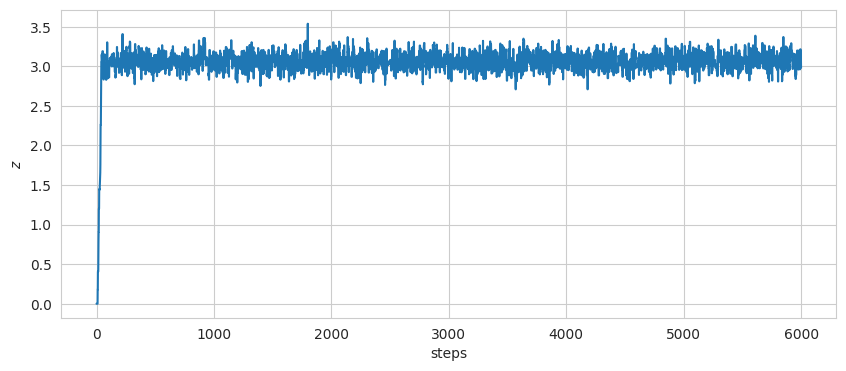

In [8]:
# Trace-plot の描画
plt.figure(figsize=(10, 4))
plt.plot(posterior, lw=1.5)
plt.xlabel("steps")
plt.ylabel("$z$")

バーンイン期間（barn-in, ※ 別名: warm-up）
MCMC の最初の方に Sample が初期値の影響によって定常分布に達していないことにより事後分布の分析に用いずに捨ててしまうこと。

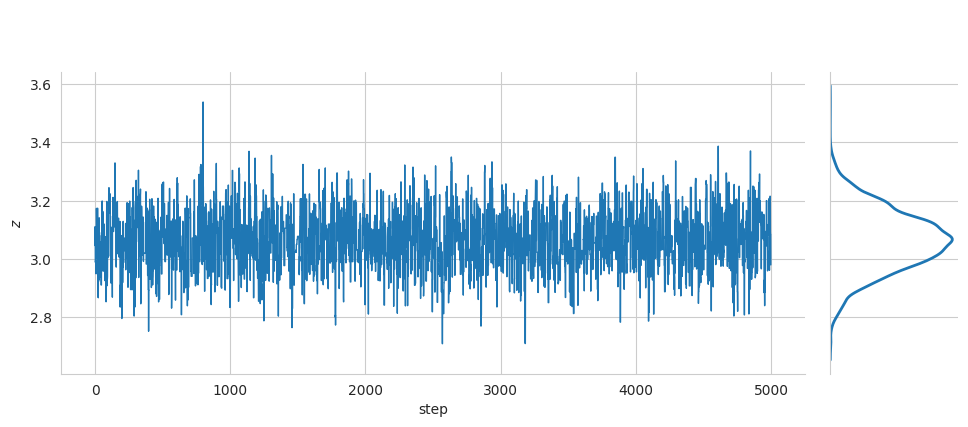

In [9]:
# 最初の 1000Step を Barn-in期間として除外して Trace-plot を描画
n_burnin = 1000
x, y = np.arange(n_iter - n_burnin), posterior[n_burnin:]

# seaborn で複数の Plot を組み合わせるための Class
g = sns.JointGrid()
# Main の Plot
sns.lineplot(x=x, y=y, linewidth=1, ax=g.ax_joint)
# y軸に付属する Plot
sns.kdeplot(y=y, linewidth=2, ax=g.ax_marg_y)
g.ax_joint.set_xlabel("step")
g.ax_joint.set_ylabel("$z$")
g.ax_marg_x.set_axis_off()
g.fig.set_figwidth(10)
g.fig.set_figheight(4)

Sample が一定の分布に従い、安定して変動しているため、MCMC は問題なく定常分布に収束したといえる。（=MCMC により推定された事後分布）

#### MCMC が収束しない例を確認する

In [10]:
def randomwalk_MH(x_init, step_size=0.3, n_iter=6000, n_burnin=1000):
    x_current = x_init
    posterior = []

    for _ in tqdm(range(n_iter)):
        x_proposal = x_current + step_size * np.random.uniform(-1, 1)

        r = np.random.rand()
        logp_current = unnormalized_log_posterior(x_current)
        logp_prop = unnormalized_log_posterior(x_proposal)
        if np.exp(logp_prop - logp_current) > r:
            x_current = x_proposal
        posterior.append(x_current)

    return posterior[n_burnin:]

100%|██████████| 4000/4000 [00:09<00:00, 401.45it/s]


Text(0, 0.5, 'z')

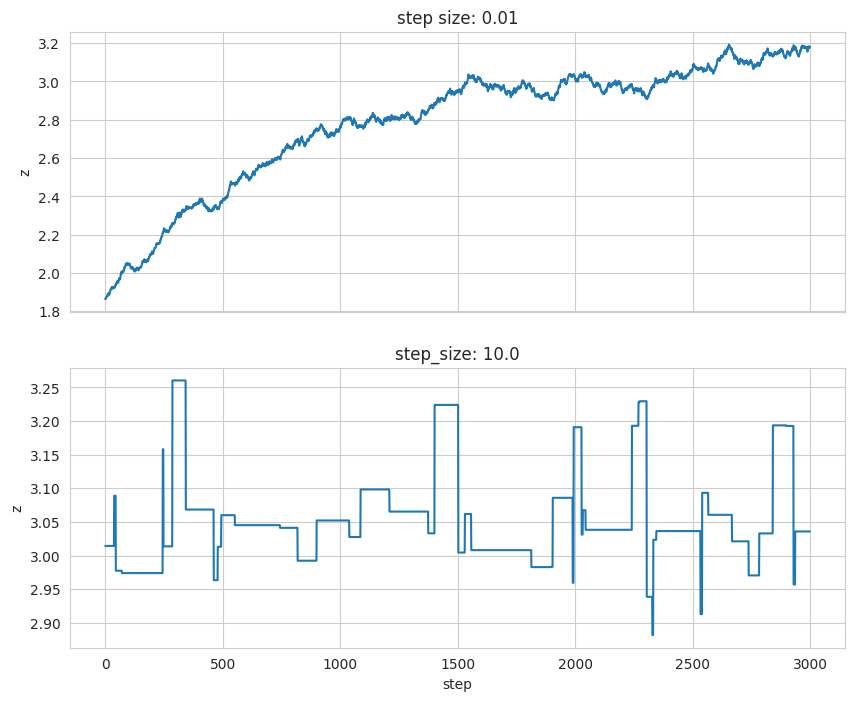

In [11]:
# Step size が小さすぎる場合
posterior_small_step = randomwalk_MH(0, 0.01, 4000, 1000)
# Step size が大きすぎる場合
posterior_large_step = randomwalk_MH(0, 10.0, 4000, 1000)

# Trace-plot
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(10, 8))
ax = axes[0]
ax.plot(posterior_small_step)
ax.set_title("step size: 0.01")
ax.set_ylabel("z")

ax = axes[1]
ax.plot(posterior_large_step)
ax.set_title("step_size: 10.0")
ax.set_xlabel("step")
ax.set_ylabel("z")

- Step size が小さすぎる場合(0.01)、受容率は高くなるが、Sample は少しずつしか変化しない。
- Step size が大きすぎる場合(10.0)、受容率が極端に低くなってしまい、Sample がなかなか変化しない。

いずれの場合も定常分布に収束したとはいえない。

MCMC が収束しない場合、典型的には Sample の **自己相関（autocorrelation）** が高くなっている。
自己相関が高い場合、各Step で得られた Sample が以前の Sample の影響を強く受けており、定常分布からの独立な Sample とみなせなくなる。

#### 自己相関を確認する
コレログラム（Correlogram）を描画して Sample の自己相関を確認する。

Text(0, 0.5, 'autocorr')

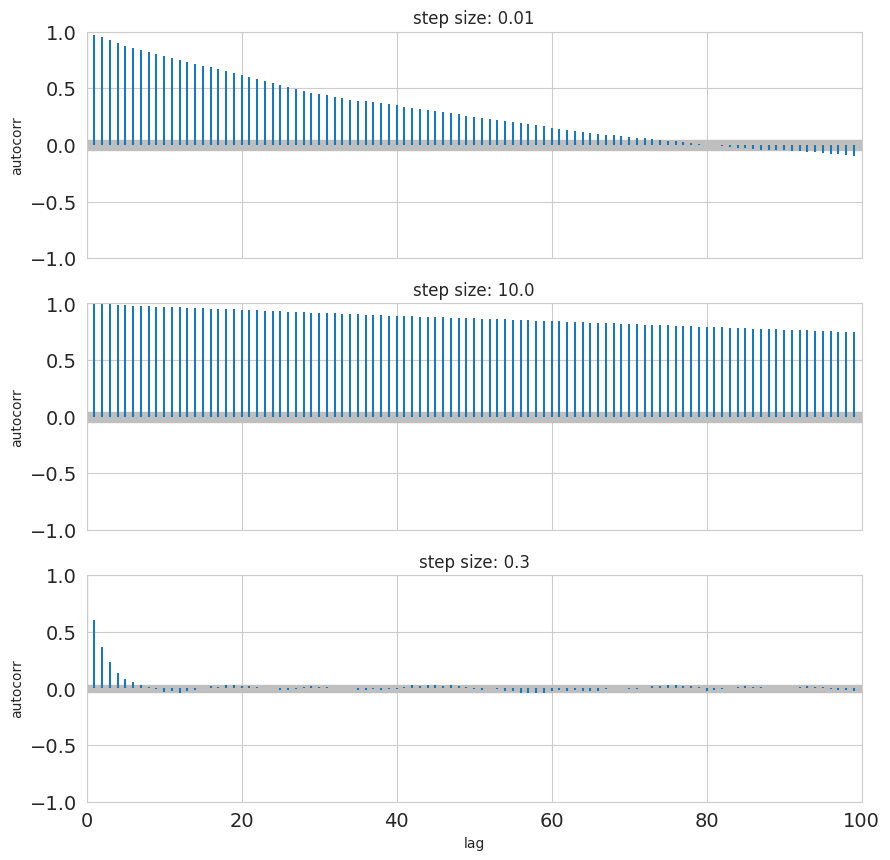

In [12]:
fig, axes = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
ax = axes[0]
az.plot_autocorr(np.array(posterior_large_step[n_burnin:]), ax=ax)
ax.set_title("step size: 0.01")
ax.set_ylabel("autocorr")

ax = axes[1]
az.plot_autocorr(np.array(posterior_small_step[n_burnin:]), ax=ax)
ax.set_title("step size: 10.0")
ax.set_ylabel("autocorr")

ax = axes[2]
az.plot_autocorr(np.array(posterior[n_burnin:]), ax=ax)
ax.set_title("step size: 0.3")
ax.set_xlabel("lag")
ax.set_ylabel("autocorr")

Step size: 0.3 の場合はほとんど自己相関がないの対し、Step-size: 0.01, 10.0 は自己相関が高くなっている。

#### 一般的な MCMC が正しく収束したかの判断方法
複数の初期値で MCMC を実施し、結果を比較する。
Trace-plot に複数の **Chain** （MCMC で得られる一連の Sample例）を描画し、これらがよく混ざりあっていることが好ましい。

In [14]:
# Random に選んだ３つの初期値で MCMC を行ない、結果を重ねて表示

# ３つの Chain による Sampling
x_inits = np.random.uniform(-1, 1, 3)
posteriors = [randomwalk_MH(x_init) for x_init in x_inits]
posteriors = np.array(posteriors).transpose()
posteriors

100%|██████████| 6000/6000 [00:14<00:00, 405.58it/s]


array([[3.14284251, 3.08289508, 3.10557774],
       [3.14284251, 2.98648266, 2.96831247],
       [3.20160732, 2.98648266, 3.12084035],
       ...,
       [3.30086948, 3.01633864, 2.99445015],
       [3.30086948, 3.01633864, 2.99445015],
       [3.08981389, 3.10809438, 3.17349793]])

Text(0, 0.5, 'z')

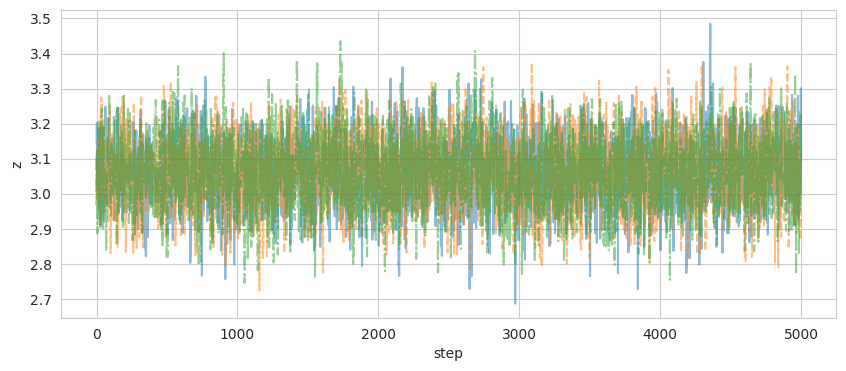

In [15]:
# Trace-plot
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(posteriors[:, 0], lw=1.5, alpha=0.5)
ax.plot(posteriors[:, 1], lw=1.5, alpha=0.5, ls="--")
ax.plot(posteriors[:, 2], lw=1.5, alpha=0.5, ls="-.")
ax.set_xlabel("step")
ax.set_ylabel("z")

Text(0.5, 0, 'z')

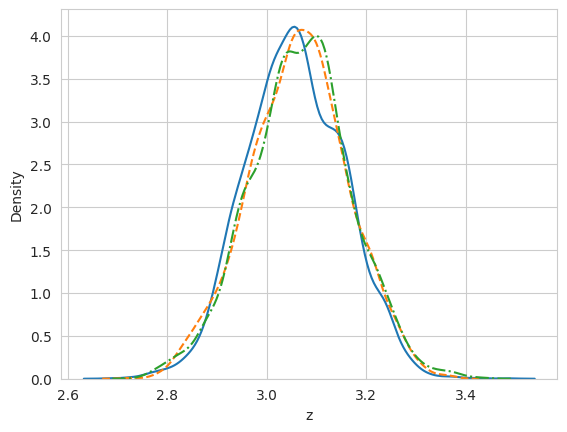

In [16]:
# 事後分布の可視化
fig, ax = plt.subplots()
sns.kdeplot(posteriors[:, 0])
sns.kdeplot(posteriors[:, 1], ls="--")
sns.kdeplot(posteriors[:, 2], ls="-.")
ax.set_xlabel("z")

- Trace-plot は３つの Chain がよく混ざり合っている
- 事後分布もほぼ重なっている

以上より、収束に問題はないと判断できる。

#### 統計量 Rhat
Parameter が多数の場合に確認することで、収束の判断ができる。
- 各Chain内での分散と、Chain間の分散を比較した指標。
- １に近いほど好ましく、基本的には 1.1以下ならばよいとされている。
- 目標分布に Peak が複数ある場合などは、判断が難しい Case もある。

In [18]:
rhat = az.rhat(posteriors.transpose())
print(f"Rhat: {rhat:.3f}")

Rhat: 1.001


Rhat を算出しても収束に問題なさそうである。

### 変分推論法（Variational inference method）
MCMC のように Sampling を行なうのではなく、最適化により近似推論を行なう Approach。
- 一般的に MCMC よりも高速な推論が可能。
- MCMCのように必ず真の事後分布を正確に表現できる保証がなく、推論の精度についてはまだ明らかになっていない面がある。
- 下記、1~3 より、変位推論法は、ELOB を最大化することで、事後分布の近似推論を行なう方法と言える。
1. 事後分布を簡単な確率分布（近似分布）で近似する
    >近似分布は、変分Parameter で表せれる任意の確率分布などを用いる。
2. 近似分布が真の事後分布をどれだけよく近似できているかは、**KL ダイバージェンス（Kullback-Leibler divergence）** により評価できる。
    >KL divergence
    > - ２つの確率分布が類似しているほど小さい値をとる。
    > - ２つの確率分布が完全に一致している場合は、最小値である 0 をとる。
    > - 0 以上の値をとる
3. KL divergence の最小化は **エビデンス下界（ELBO: Evidence lower bound）** の最大化と同じことになる。
    > ELBO
    > 対数周辺尤度（Evidence）より大きくなることなない。

### 平均場近似（Mean-Field approximation）
変分推論法でよく用いられる手法。
- 平均場近似との組み合わせでよく使われるのが各因子について、ELOB を最大化するように順番に最適化していく手法。
> **座標上昇法（Coordinate ascent method）** に基づく変分推論法といえる。
- 期待値計算が解析的に求められれば非常に効率がよい。
- PPL の実装という観点では、User が任意に構築した Model について、期待値計算により効率的な Algorithm を導出することは難しく、特に Data-size が大きい場合は、より効率的な計算方法が必要になる。そのため、PPL では、一部の Data を使って ELOB の勾配を近似的に計算する確率的変分推論法が主に用いられる。